In [3]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [16]:
def model_perform(X_train,y_train, X_test, y_test, model, name, verbose = 0 ):
    # train 
    model.fit(X_train, y_train)

    # test 
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)


    if verbose == 1 :
        print(' MAE {} '.format(mean_absolute_error(y_pred_test,y_test)))
        print(' MSE {} '.format(mean_squared_error(y_pred_test,y_test)))
        print(' R2 {} '.format(r2_score(y_train,y_pred_train)))
    else : 
        pass 
    
    result = {}
    result['mae'] = mean_absolute_error(y_pred_test,y_test)
    result['mse'] = mean_squared_error(y_pred_test,y_test)
    result['R2'] = r2_score(y_train,y_pred_train)
    result['name'] = name

    return model, y_pred_test, y_pred_train, result 

def show_error_pattern(y_pred, y_test):
    result_test = pd.DataFrame()
    result_test['score'] = y_pred
    result_test['type'] = 'predict'
    result_test['idx'] = np.arange(result_test.shape[0])

    result_test2 = pd.DataFrame()
    result_test2['score'] = np.squeeze(y_test)
    result_test2['type'] = 'test'
    result_test2['idx'] = np.arange(result_test2.shape[0])

    df_result = pd.concat([result_test2,result_test])

    sns.lineplot(data=df_result, x="idx", y='score', hue="type")


def bulk_train(df_input, drop_column, target_column, dataset_name, verbose = 0):

    error_report = []
    model_dict = {}
    # split train and test 
    X_train, X_test, y_train, y_test = train_test_split(df_input.drop(drop_column,axis=1), df_input[target_column], test_size=0.2, random_state=42)

    regr = RandomForestRegressor(random_state=0)
    model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose = verbose )
    error_report.append(result_rf)

    xgbr = XGBRegressor(random_state=0)
    model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name='xgb', verbose = verbose)
    error_report.append(result_xgb)

    # SVR 
    svr = SVR(kernel='poly')

    scaler=MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.fit_transform(X_test)
    model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train_scale, y_train, X_test_scale, y_test, svr, name='svr',verbose = verbose)
    error_report.append(result_svr)

    model_dict['rf'] = model_regr
    model_dict['xgbr'] = result_xgb
    model_dict['svr'] = result_svr
    
    df_report = pd.DataFrame(error_report)
    df_report['dataset'] = dataset_name
    return  model_dict, df_report

# Bulk Training 

In [22]:
# zomato only
df_zom = pd.read_csv('data/3_clean_zomato_feat.csv')
df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']
target_column = 'rating'
model_zom, report_zom = bulk_train(df_input=df_zom, drop_column=drop_column, target_column=target_column, dataset_name='zomato_only')

In [32]:
# zomato geo 250
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_250.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash']
target_column = 'rating'
model_zom_geo_250, report_zom_geo_250 = bulk_train(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_geo_250')

In [33]:
# zomato geo 500
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_500.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash']
target_column = 'rating'
model_zom_geo_500, report_zom_geo_500 = bulk_train(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_geo_500')

In [34]:
# zomato geo 1000
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_1000.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash']
target_column = 'rating'
model_zom_geo_1000, report_zom_geo_1000 = bulk_train(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_geo_1000')

In [35]:
all_df_error_report = pd.concat([report_zom, report_zom_geo_250, report_zom_geo_500, report_zom_geo_1000])

In [36]:
all_df_error_report.reset_index().drop('index',axis=1)

,mae,mse,R2,name,dataset
0,0.366335,0.219131,0.812726,rf,zomato_only
1,0.364620,0.218982,0.650282,xgb,zomato_only
2,0.439059,0.283495,0.032464,svr,zomato_only
3,0.365863,0.215182,0.870960,rf,zomato_geo_250
4,0.370724,0.225264,0.745789,xgb,zomato_geo_250
5,0.441580,0.290528,0.100067,svr,zomato_geo_250
6,0.355995,0.203427,0.878681,rf,zomato_geo_500
7,0.368865,0.226204,0.833293,xgb,zomato_geo_500
8,0.396356,0.252861,0.132381,svr,zomato_geo_500
9,0.355995,0.203427,0.878681,rf,zomato_geo_1000


# Load data 

##  Zomato data only 

In [11]:
# df = pd.read_csv('data/3_clean_zomato_gof_1000.csv')
df_zom = pd.read_csv('data/3_clean_zomato_feat.csv')
df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)
# df['rank_res_type'] = df['rank_res_type'].astype(int)
# df['rank_fac'] = df['rank_fac'].astype(int)

<AxesSubplot:ylabel='Frequency'>

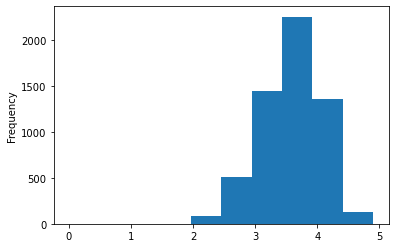

In [12]:
df_zom['rating'].plot(kind='hist')

In [13]:
df_zom.head()

,index,url,rest_price_idr,review,lat,long,is_chain,rating,new_code_res_type,rank_res_type,new_code_fac,rank_fac
0,0,https://www.zomato.com/jakarta/wakacao-1-kelap...,150,56.0,-6.167531,106.901752,0,3.8,4,0,4,0
1,1,https://www.zomato.com/jakarta/the-coffee-bean...,110,61.0,-6.157341,106.907888,1,3.0,0,91,0,1353
2,2,https://www.zomato.com/jakarta/angke-kelapa-ga...,450,363.0,-6.152638,106.892576,0,4.5,2,2,0,907
3,3,https://www.zomato.com/jakarta/ikan-nila-pak-u...,100,113.0,-6.163588,106.903689,0,3.9,0,20,0,4
4,4,https://www.zomato.com/jakarta/hong-kong-sheng...,220,257.0,-6.157255,106.908430,1,4.1,0,275,0,83


# Preprocessing 

In [16]:
# scaler = MinMaxScaler()
# Y = scaler.fit_transform(df[['rating']])
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['url','index','rating','lat','long','review','new_code_res_type','new_code_fac'],axis=1), Y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['url','index','rating','lat','long','review'],axis=1), Y, test_size=0.3, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(df_zom.drop(['url','index','rating','lat','long','review','new_code_res_type','new_code_fac'],axis=1), df_zom['rating'], test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['url','index','rating','lat','long','review'],axis=1), df['rating'], test_size=0.3, random_state=42)

In [17]:
X_train.head()

,rest_price_idr,is_chain,rank_res_type,rank_fac
3071,90,1,139,25
2860,100,0,177,439
4694,100,0,26,19
5696,100,1,7,4
3107,70,0,4,38


In [18]:
X_train.shape

(4642, 4)

 MAE 0.36633482606857976 
 MSE 0.2191306338953765 
 R2 0.8127255130705369 


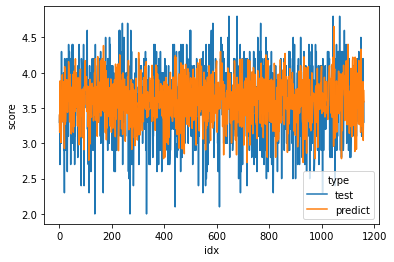

In [25]:
# random forest 

regr = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose =1 )

show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

# show_error_pattern(y_pred=y_pred_train_regr, y_test=y_train)

 MAE 0.364620226934796 
 MSE 0.21898204876223926 
 R2 0.6502822134666157 


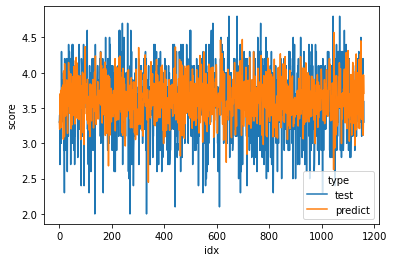

In [26]:
# XGBoost 

xgbr = XGBRegressor(random_state=0)
model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name = 'xgb', verbose = 1)

show_error_pattern(y_pred=y_pred_test_xgbr, y_test=y_test)

 MAE 0.43905875430546726 
 MSE 0.2834954313018201 
 R2 0.03246429811310769 


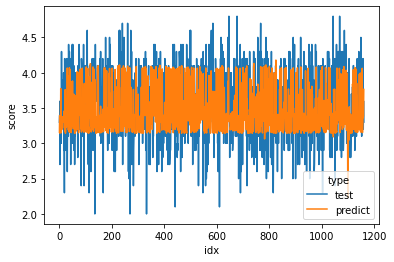

In [24]:
# SVR 
svr = SVR(kernel='poly')

scaler=MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)
model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train_scale, y_train, X_test_scale, y_test, svr, name = 'svr',verbose = 1)

show_error_pattern(y_pred=y_pred_test_svr, y_test=y_test)

# Zomato + POI 

In [27]:
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_250.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_zom_poi.drop(['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash'],axis=1), \
    df_zom_poi['rating'], test_size=0.2, random_state=42)


 MAE 0.3658632572494975 
 MSE 0.21518212523593575 
 R2 0.8709598920956778 


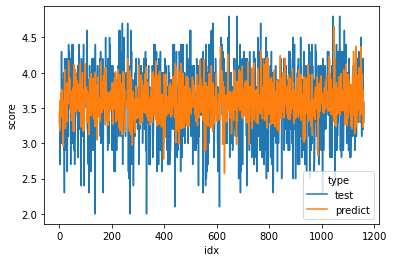

In [30]:
# random forest 

regr = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose =1 )

show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

 MAE 0.3707243080697729 
 MSE 0.22526403441616144 
 R2 0.7457887370792846 


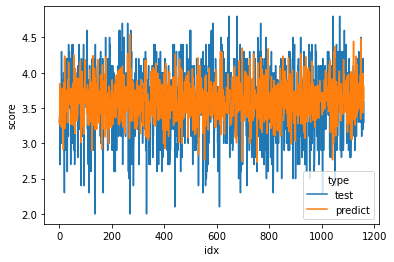

In [31]:
# XGBoost 

xgbr = XGBRegressor(random_state=0)
model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name = 'xgb',verbose = 1)

show_error_pattern(y_pred=y_pred_test_xgbr, y_test=y_test)

 MAE 0.4415803039854781 
 MSE 0.29052763390183667 
 R2 0.10006736419081175 


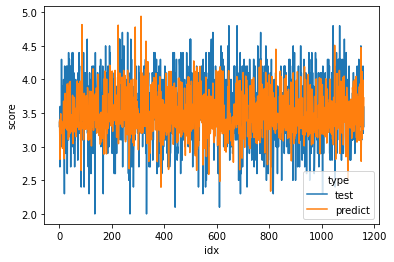

In [32]:
# SVR 
svr = SVR(kernel='poly')

scaler=MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)
model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train_scale, y_train, X_test_scale, y_test, svr, name='svr' ,verbose = 1)

show_error_pattern(y_pred=y_pred_test_svr, y_test=y_test)

In [17]:
# feature importance 
df_feat = pd.DataFrame({'score':model_xgbr.feature_importances_,'columns':X_train.columns})
df_feat.sort_values('score',ascending=False)


,score,columns
0,0.070212,rest_price_idr
19,0.063133,d_250_train_station
17,0.055762,d_250_store
11,0.053968,d_250_lodging
10,0.053558,d_250_hospital
2,0.051739,rank_res_type
14,0.050521,d_250_park
20,0.049820,en_250
16,0.049561,d_250_school
7,0.049434,d_250_cafe
